

#### Data Processing 

+ train VAE to learn healthy distribution of mr adult brain images HCP
    + try three different resolutions: patches, slices, 3d volumes. Start from slices
+ processing code
    + https://github.com/MIC-DKFZ/vae-anomaly-experiments/blob/master/utils/preprcess_brain.py
    
    
    
+ `data/hcp1200_v2`
    + `resize_zero_padding_nd` to 260, 320, 260
    + standardize to zero mean and unit variance
    + transpose and re-ordered to conform with training code.
    + remember to use `slice_offset=50` to avoid excessive number of blank slices.



In [1]:
# /data/vision/polina/shared_software/miniconda3/envs/inr/bin/python
#
import sys
sys.path.insert(1, '/data/vision/polina/scratch/dmoyer/nn_utils')
sys.path.insert(1, '/data/vision/polina/scratch/wpq/github/code_snippets')
from nn_utils.data_tools.simple_preproc import resize_zero_padding_nd
from code_snippets.plot import plt_slices

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as snd
from medpy.io import load

from data import brain_ds


In [14]:
vol_size = (260,320,260)

proc_hcp = False
proc_atlas = True


def normalize_dmoyer(vol):
    """ Normalize volume `vol` by clipping extreme values 
        such that intensities roughly lies in the [0, 1] range 
        `vol_max` and `vol_denom` different to preserve dynamic range
    """
    vol = np.copy(vol)
    vol_max = np.quantile(vol,0.995)
    vol_denom = np.quantile(vol,0.99)
    vol = np.clip(vol, 0, vol_max)
    vol /= vol_denom
    return vol


def normalize_ad(vol):
    """ Normalize volume `vol` by μ,σ statistics
        Just compute this on-the-fly in torchvision transforms
    """
    vol = np.copy(vol)
    mask = np.where(vol != 0)
    vol_mask = vol[mask]
    μ = np.mean(vol_mask)
    σ = np.std(vol_mask) + 1e-8
    vol[mask] = (vol[mask]-μ)/σ
    return vol

def proc_vol(vol, normalize=True):
    vol = resize_zero_padding_nd(vol, vol_size)
    if normalize:
        vol = normalize_ad(vol)
    vol = vol.transpose((2, 1, 0))[:, ::-1, :] # Needed to conform with training code.
    return vol


1064


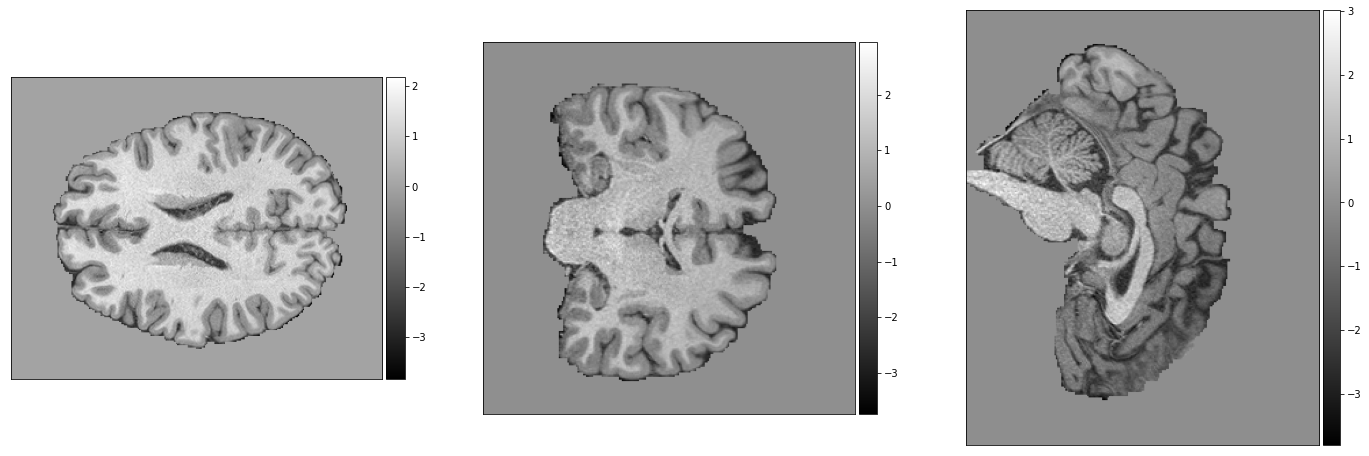

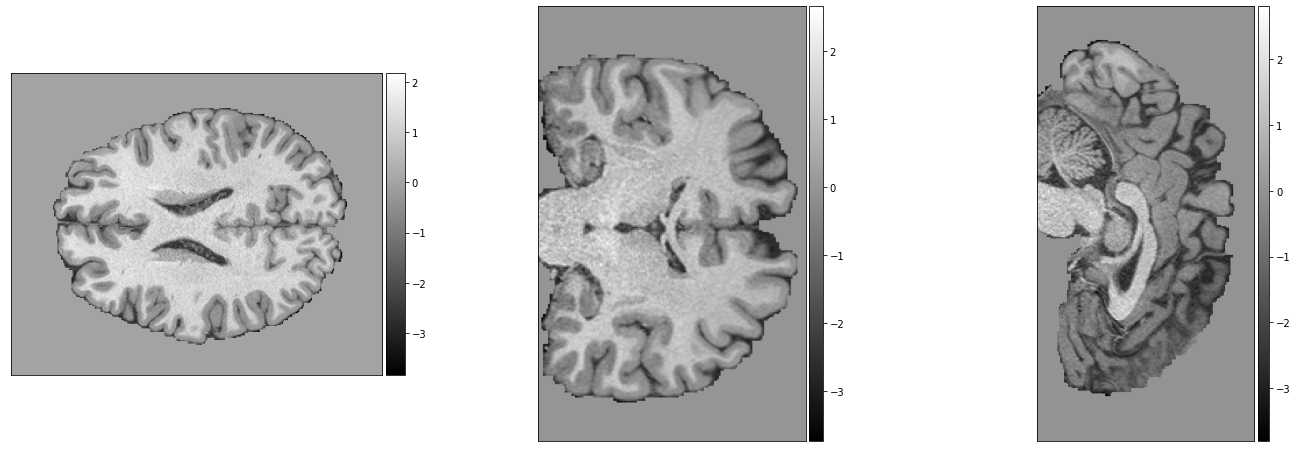

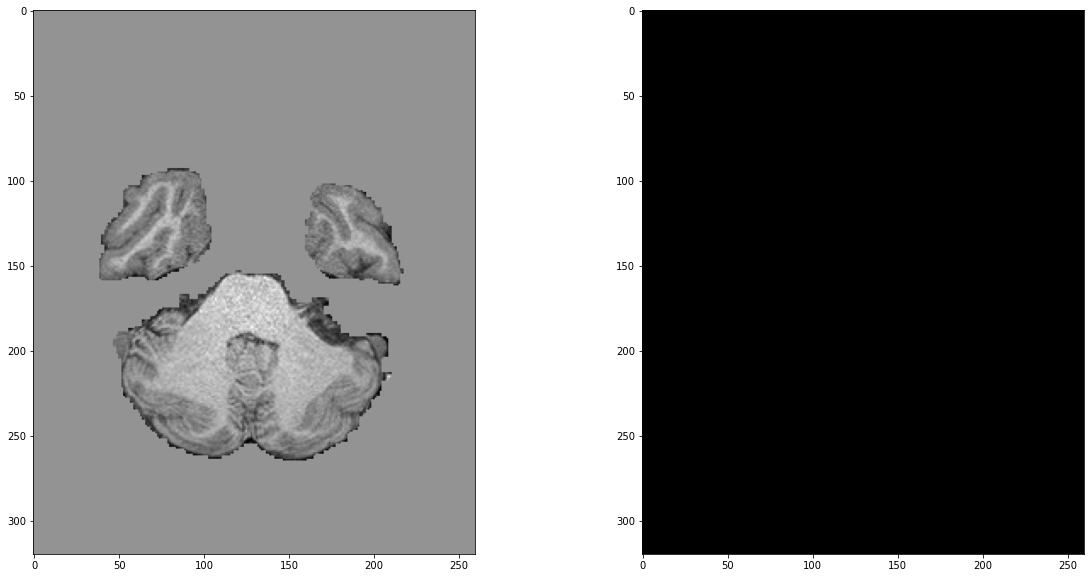

In [22]:
# hcp1200, n=1064 selected by dmoyer, 
# shape: (260, 311, 260)->(260, 320, 260)
#
with open('/data/vision/polina/scratch/dmoyer/inr-mr/t1_list.csv') as f:
    hcp1200_vol = [line.rstrip('\n') for line in f]

hcp1200_vol = [os.path.join('/data/vision/polina/scratch/dmoyer/hcp_3T_7T_diffusion', x)
               for x in hcp1200_vol]
hcp1200_subject = [x.split('/')[-3] for x in hcp1200_vol]

# # All opens
# for x in nii_list:
#     assert(os.path.isfile(x))

print(len(hcp1200_vol))

vol = nib.load(hcp1200_vol[0]).get_fdata()
vol = proc_vol(vol)
plt_slices(vol)
slice_offset = 50
s = slice(slice_offset,-slice_offset)
plt_slices(vol[s,:,:])

fig, axs = plt.subplots(1,2,figsize=(20,10))
ax = axs[0]
ax.imshow(vol[slice_offset, :, :], cmap='gray')
ax = axs[1]
ax.imshow(vol[-slice_offset, :, :], cmap='gray')

In [95]:
# Just to visualize what `slice_offset` does to hcp volumes
#
# t1_array = nib.load(hcp1200_vol[0]).get_fdata()
# t1_array = snd.zoom(t1_array, (0.75, 0.75, 0.75), order=1)
# t1_array = t1_array.transpose((2, 1, 0))[:, ::-1, :]
# print(t1_array.shape) # (195, 233, 195)
# t1_array = t1_array[0:165, 15:225, 15:180]
# print(t1_array.shape) # (165, 210, 165)  <- (260, 320, 260)
# slice_offset = 20
# s = slice(slice_offset,-slice_offset)
# plt_slices(t1_array[s,:,:])

# fig, axs = plt.subplots(1,2,figsize=(18,9))
# ax = axs[0]
# ax.imshow(t1_array[slice_offset, :, :], cmap='gray')
# ax = axs[1]
# ax.imshow(t1_array[-slice_offset, :, :], cmap='gray')

In [4]:
if proc_hcp:
    start_dir = '/data/vision/polina/scratch/dmoyer/hcp_3T_7T_diffusion/data/downloaded/'
    target_dir = './data/hcp1200_v2/'

    n_vols = 0        
    for subj in hcp1200_subject: # 1064 patients, 49 missing

        sub_dir = os.path.join(start_dir, subj, 'hcp1200')
        if os.path.isdir(sub_dir):
            t1_file = os.path.join(sub_dir, "T1w_acpc_dc_restore_brain.nii.gz")
            t2_file = os.path.join(sub_dir, "T2w_acpc_dc_restore_brain.nii.gz")
            label_file = os.path.join(sub_dir, "wmparc.nii.gz")

            t1_array = nib.load(t1_file).get_fdata().astype(np.float32)
            t2_array = nib.load(t2_file).get_fdata().astype(np.float32)
            label_array = nib.load(label_file).get_fdata().astype(np.float32)

            t1_array = proc_vol(t1_array)
            t2_array = proc_vol(t2_array)
            label_array = proc_vol(label_array, normalize=False)

            final_array = np.stack((t1_array, t2_array, label_array))
            target_file = os.path.join(target_dir, subj + ".npy")
            np.save(target_file, final_array)
            n_vols = n_vols + 1
            print(n_vols, target_file)
            break

1 ./data/hcp1200_v2/100206.npy


In [16]:
if proc_hcp:
    plt_slices(final_array[2][50:-50,:,:])

655


(<Figure size 1728x576 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc855f30d0>,
       dtype=object))

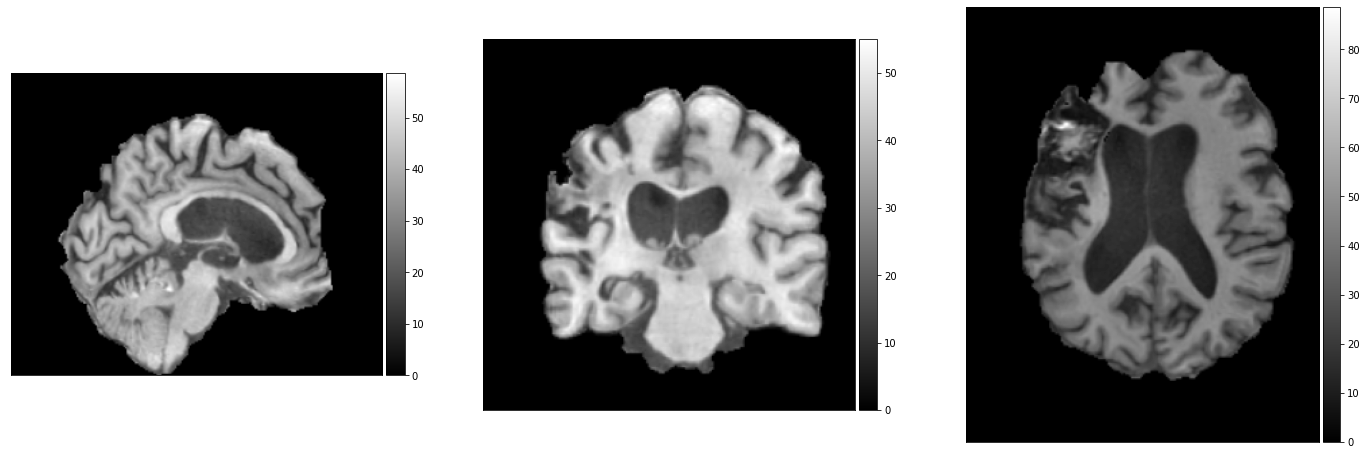

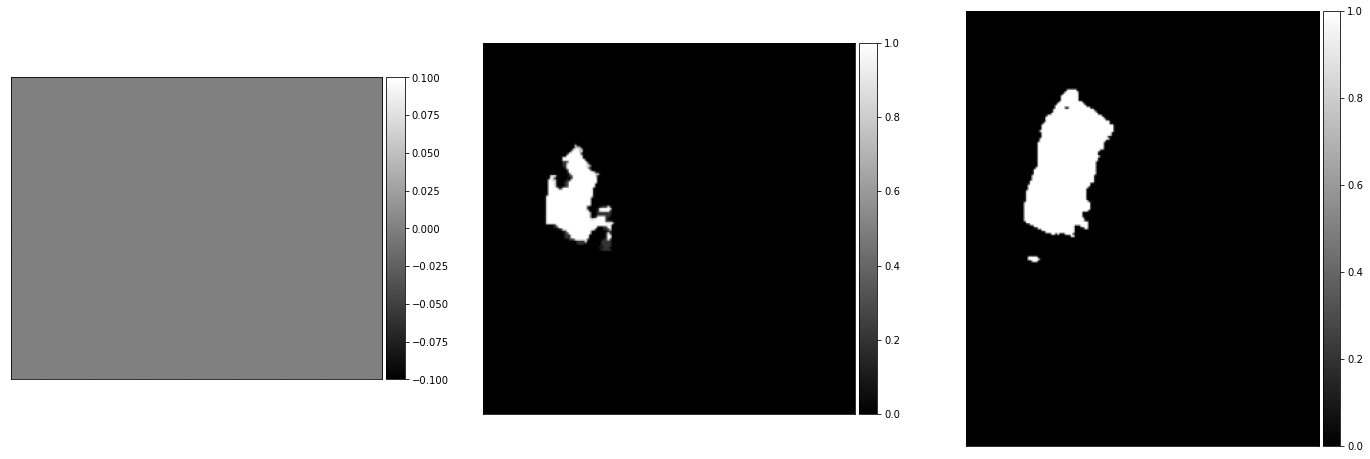

In [17]:
# ATLAS 2.0 stroke lesion dataset. n=655
# shape: (260, 311, 260)->(260, 320, 260)
# 
df = pd.read_csv('/data/vision/polina/scratch/dmoyer/ATLAS_2/linked_vols/vols.csv')
atlas2_subj_list = df['subj_id'].to_list()

atlas2_vol = [f'/data/vision/polina/scratch/dmoyer/ATLAS_2/linked_vols/{x}.nii.gz' for x in atlas2_subj_list]
atlas2_mask = [f'/data/vision/polina/scratch/dmoyer/ATLAS_2/linked_vols/{x}_mask.nii.gz' for x in atlas2_subj_list]
atlas2_lesion_mask = [f'/data/vision/polina/scratch/dmoyer/ATLAS_2/linked_vols/{x}_lesion_mask.nii.gz' for x in atlas2_subj_list]

print(len(atlas2_subj_list))

vol = nib.load(atlas2_vol[0]).get_fdata()
vol = resize_zero_padding_nd(vol, (260,320,260))
plt_slices(vol)

vol = nib.load(atlas2_lesion_mask[0]).get_fdata()
vol = resize_zero_padding_nd(vol, (260,320,260))
plt_slices(vol)

In [18]:
###### ATLAS2
# 
if proc_atlas:
    start_dir = "/data/vision/polina/scratch/dmoyer/ATLAS_2/linked_vols/"
    target_dir = "./data/atlas2/"

    n_vols = 0

    for subj in atlas2_subj_list: # n=655

        vol_file = os.path.join(start_dir, f'{subj}.nii.gz')
        mask_file = os.path.join(start_dir, f'{subj}_mask.nii.gz')
        lesion_mask_file = os.path.join(start_dir, f'{subj}_lesion_mask.nii.gz')

        assert(os.path.isfile(vol_file))
        assert(os.path.isfile(mask_file))
        assert(os.path.isfile(lesion_mask_file))

        vol = nib.load(vol_file).get_fdata().astype(np.float32)
        mask = nib.load(mask_file).get_fdata().astype(np.float32)
        lesion_mask = nib.load(lesion_mask_file).get_fdata().astype(np.float32)

        vol = proc_vol(vol)
        mask = proc_vol(mask, normalize=False)
        lesion_mask = proc_vol(lesion_mask, normalize=False)

        final_array = np.stack((vol, mask, lesion_mask))
        target_file = os.path.join(target_dir, subj + '.npy')
        np.save(target_file, final_array)
        n_vols = n_vols + 1
        print(n_vols, target_file)
        break
    


1 ./data/atlas2/sub-r001s001_ses-1.npy


(3, 260, 320, 260)


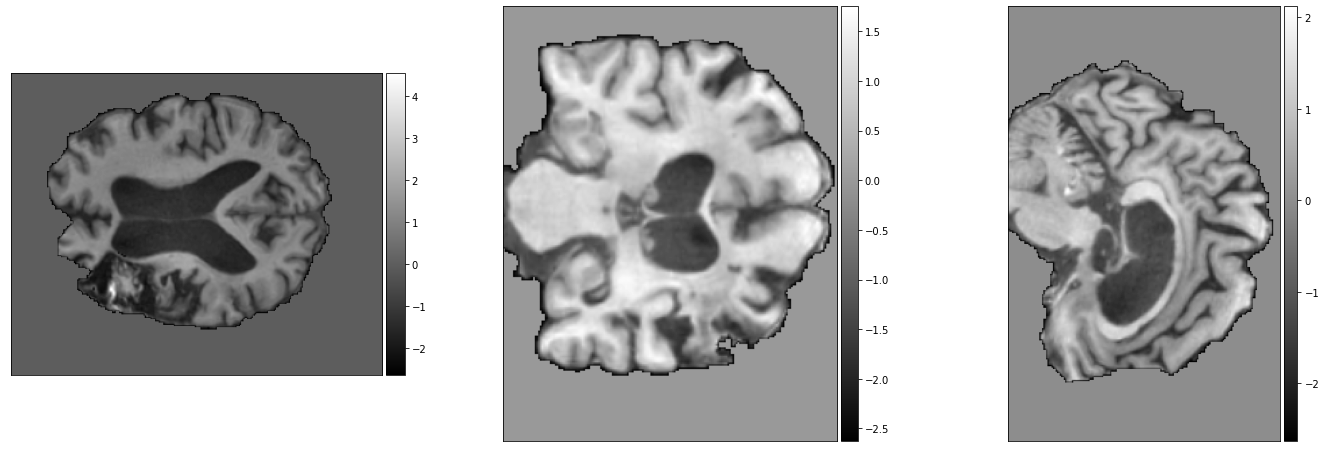

In [25]:
# Just to visualize what `slice_offset` does to atlas2 volumes
#
if proc_atlas:
    slice_offset = 30
    s = slice(slice_offset,-slice_offset)
    plt_slices(final_array[0,s,:,:])
    
print(final_array.shape)